# Autocorrelation: Exploring Rossmann Drug Store Sales Data
#### Jonathan Balaban

This lab sets the foundation for ARIMA modeling. We will get to know our dataset, cover basic theory, and explore Python methods for managing time series data.

Time series data usually contains more than meets the eye, and can often be decomposed into trend, seasonal, and random fluctuation components.

![Decomposition](http://rstatistics.net/wp-content/uploads/2014/09/Multiplicative-Decomposition-of-Time-series.png)

- Trends
    - Up
    - Down
    - Flat
    - Larger trends can be made up of smaller trends
    - There is no defined timeframe for what constitutes a trend; it depends on your goals
- Seasonal Effects
    - Weekend retail sales spikes
    - Holiday shopping
    - Energy requirement changes with annual weather patterns
    - Note: twitter spikes when news happens are not seasonal; they aren't regular and predictable
- Random Fluctuations
    - The human element
    - Aggregations of small influencers
    - Observation errors
    - The smaller this is in relation to Trend and Seasonal, the better we can predict the future
    
Time series models fall into [two camps](http://www.abs.gov.au/websitedbs/D3310114.nsf/home/Time+Series+Analysis:+The+Basics#HOW%20DO%20I%20KNOW%20WHICH%20DECOMPOSITION):
- Additive
    - Data = Trend + Seasonal + Random
    - What we will be using for our modeling
- Multiplicative
    - Data = Trend x Seasonal x Random
    - As easy to fit as Additive if we take the log
    - log(Data) = log(Trend x Seasonal x Random)

We should use multiplicative models when the percentage change of our data is more important than the absolute value change (e.g. stocks, commodities); as the trend rises and our values grow, we see amplitude growth in seasonal and random fluctuations.

## Time Series Modeling Process
Time series model selection is driven by the Trend and Seasonal components of our raw data. The general approach for analysis looks like this:

1. Plot the data and determine Trends and Seasonality
    1. Difference the data (multiple times if needed) to remove trends for [certain model applications](https://en.wikipedia.org/wiki/Stationary_process)
    1. Stationairity is needed for ARMA models
1. Determine if we have additive or multiplicative data patterns
1. Select the appropriate algorithm based on the chart below
1. Determine if model selection is correct with these tools
    - Ljung-Box Test
    - Residual Errors (Normal Distribution with zero mean and constant variance-homoskedastic)
    - Autocorrelation Function (ACF)
    - Partial Autocorrelation Function (PACF)

Algorithm | Trend | Seasonal | Correlations
---|---|---|---
ARIMA | X |X|X
SMA Smoothing |X||
Simple Exponential Smoothing |X||
Seasonal Adjustment |X|X|
Holt's Exponential Smoothing |X||
Holt-Winters |X|X|




In [1]:
# import packages and data
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('rossmann.csv', skipinitialspace=True, low_memory=False)

In [12]:
data['Date']

0          2015-07-31
1          2015-07-31
2          2015-07-31
3          2015-07-31
4          2015-07-31
5          2015-07-31
6          2015-07-31
7          2015-07-31
8          2015-07-31
9          2015-07-31
10         2015-07-31
11         2015-07-31
12         2015-07-31
13         2015-07-31
14         2015-07-31
15         2015-07-31
16         2015-07-31
17         2015-07-31
18         2015-07-31
19         2015-07-31
20         2015-07-31
21         2015-07-31
22         2015-07-31
23         2015-07-31
24         2015-07-31
25         2015-07-31
26         2015-07-31
27         2015-07-31
28         2015-07-31
29         2015-07-31
              ...    
1017179    2013-01-01
1017180    2013-01-01
1017181    2013-01-01
1017182    2013-01-01
1017183    2013-01-01
1017184    2013-01-01
1017185    2013-01-01
1017186    2013-01-01
1017187    2013-01-01
1017188    2013-01-01
1017189    2013-01-01
1017190    2013-01-01
1017191    2013-01-01
1017192    2013-01-01
1017193   

In [23]:
# we are most interested in `Date` column that contains date of sales per store; convert to `DateTime` and set as index
# pull year and month as features
from datetime import datetime

data['Date'] = pd.to_datetime(data['Date'])
data.set_index(keys='Date', inplace=True)

In [28]:
data['Year']= data.index.year
data['Month']= data.index.month

In [29]:
# sort dates to ascending and view
data.sort_index(inplace='True', ascending=False)
data

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7
2015-07-31,2,5,6064,625,1,1,0,1,2015,7
2015-07-31,3,5,8314,821,1,1,0,1,2015,7
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7
2015-07-31,5,5,4822,559,1,1,0,1,2015,7
2015-07-31,6,5,5651,589,1,1,0,1,2015,7
2015-07-31,7,5,15344,1414,1,1,0,1,2015,7
2015-07-31,8,5,8492,833,1,1,0,1,2015,7
2015-07-31,9,5,8565,687,1,1,0,1,2015,7


In [30]:
# describe and EDA
data.describe().round(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Year,Month
count,1017209.00,1017209.0,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00
mean,558.43,4.0,5773.82,633.15,0.83,0.38,0.18,2013.83,5.85
std,321.91,2.0,3849.93,464.41,0.38,0.49,0.38,0.78,3.33
min,1.00,1.0,0.00,0.00,0.00,0.00,0.00,2013.00,1.00
25%,280.00,2.0,3727.00,405.00,1.00,0.00,0.00,2013.00,3.00
50%,558.00,4.0,5744.00,609.00,1.00,0.00,0.00,2014.00,6.00
75%,838.00,6.0,7856.00,837.00,1.00,1.00,0.00,2014.00,8.00
max,1115.00,7.0,41551.00,7388.00,1.00,1.00,1.00,2015.00,12.00


In [31]:
# subset data to open dates
df = data[data.Open==1]

In [32]:
# pivot table of average sales with rows=month and cols as promotion or not
pt = df.pivot_table(values='Sales', index='Month', columns='Promo')

In [33]:
# plot average sales by month and promo
pt

Promo,0,1
Month,,
1,5591.904236,7782.800277
2,5747.812834,7772.909263
3,5805.723545,8252.983345
4,5855.305439,8426.029528
5,6300.749699,8087.946860
6,5871.747172,8508.684577
7,5751.911514,8257.588809
8,5680.220869,7926.496229
9,5528.634084,7916.399032


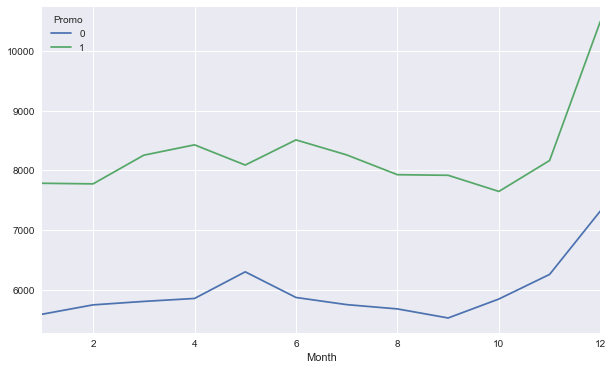

In [43]:
# plot average customers by month and promo
pt.plot(figsize=(10,6))

In [45]:
# df of store 1 open day sales
s1 = df[df.Store==1]
s1

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7
2015-07-30,1,4,5020,546,1,1,0,1,2015,7
2015-07-29,1,3,4782,523,1,1,0,1,2015,7
2015-07-28,1,2,5011,560,1,1,0,1,2015,7
2015-07-27,1,1,6102,612,1,1,0,1,2015,7
2015-07-25,1,6,4364,500,1,0,0,0,2015,7
2015-07-24,1,5,3706,459,1,0,0,0,2015,7
2015-07-23,1,4,3769,503,1,0,0,0,2015,7
2015-07-22,1,3,3464,463,1,0,0,0,2015,7


To compare sales on holidays, we can compare the sales using box-plots, which allows us to compare the distribution of sales on holidays against all other days. On state holidays the store is closed (and as a nice sanity check there are 0 sales), and on school holidays the sales are relatively similar.

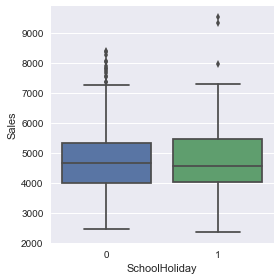

In [50]:
# do school holidays affect sales?
sns.factorplot(
    x='SchoolHoliday', y='Sales', data=s1, kind='box')

In [ ]:
# does day of week affect sales?


Lastly, we want to identify larger-scale trends in our data. How did sales change from 2014 to 2015? Were there any particularly interesting outliers in terms of sales or customer visits?

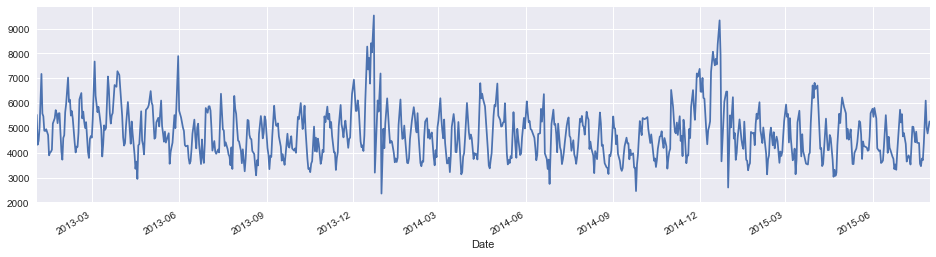

In [51]:
# plot store 1 sales when open
s1.Sales.plot(figsize=(16,4))

In [ ]:
# plot store 1 customer count when open


## Autocorrelation

To measure how much the sales are correlated with each other, we want to compute the _autocorrelation_ of the 'Sales' column. In pandas, we do this we with the `autocorr` function.

`autocorr` takes one argument, the `lag` - which is how many prior data points should be used to compute the correlation. If we set the `lag` to 1, we compute the correlation between every point and the point directly preceding it, while setting `lag` to 10, computes the correlation between every point and the point 10 days earlier.

In [ ]:
# resample all store data to average daily sales


In [ ]:
# check autocorrelation for previous two weeks
for i in range(1,16):


In [ ]:
# check yearly autocorr
for i in range(360,371):


In [ ]:
# plot autocorrelation for different lags using pandas
from pandas.tools.plotting import autocorrelation_plot
plt.figure(figsize=(20,7))


## Moving/Rolling Averages

If we want to investigate trends over time in sales, as always, we will start by computing simple aggregates.  We want to know what the mean and median sales were for each month and year.

In Pandas, this is performed using the `resample` command, which is very similar to the `groupby` command. It allows us to group over different time intervals.

We can use `data.resample` and provide as arguments:
    - The level on which to roll-up to, 'D' for day, 'W' for week, 'M' for month, 'A' for year
    - What aggregation to perform: 'mean', 'median', 'sum', etc.

In [52]:
# resample original sales data mean by week
R = df.Sales.resample('W').mean()
R.head(10)

Date
2013-01-06    5844.181391
2013-01-13    7410.922244
2013-01-20    5166.481064
2013-01-27    6907.752288
2013-02-03    5769.615869
2013-02-10    7345.567831
2013-02-17    5463.121554
2013-02-24    7132.466657
2013-03-03    5770.639175
2013-03-10    7549.112326
Freq: W-SUN, Name: Sales, dtype: float64

While identifying the monthly averages are useful, we often want to compare the sales data of a date to a smaller window. To understand holidays sales, we don't want to compare late December with the entire month, but perhaps a few days surrounding it. We can do this using rolling averages.

In [53]:
# resample to have the daily mean over all stores, then find rolling mean
for i in range(1, 16):
    print(i, R.autocorr(lag=i))

(1, -0.39232580179446019)
(2, 0.43442643772478529)
(3, -0.21611672432662513)
(4, 0.30117086353722738)
(5, -0.16184846479851264)
(6, 0.12662212931180133)
(7, -0.1331535575169035)
(8, -0.00043121873693914608)
(9, 0.081873515589125881)
(10, -0.14330895495351145)
(11, 0.047853064590498776)
(12, -0.18954029181505677)
(13, 0.12186111047124136)
(14, -0.1470058074683934)
(15, 0.08189701378699675)


`rolling` has these important parameters:
    - the first is the series to aggregate
    - `window` is the number of days to include in the average
    - `center` is whether the window should be centered on the date or use data prior to that date
    - `freq` level to roll-up averages to (as in `resample`). `D` for day, `M` for month or `A` for year, etc.

Instead of plotting the full timeseries, we can plot the rolling mean instead, which smooths random changes in sales as well as removing outliers, helping us identify larger trends.

In [ ]:
# plot rolling mean


## Pandas Window functions
Pandas `rolling` is an example of Pandas window function capabilities. Window functions operate on a set of N consecutive rows (a window) and produce an output: mean, median, min, max, sum, etc.

Another common one is `diff`, which takes the difference over time. `pd.diff` takes one arugment, `periods`, which is how many prior rows to use for the difference. This is *extremely* useful for getting our data stationary!

In addition to `rolling` functions, Pandas provides a similar collection of `expanding` functions, which instead of a window, use all values up until that time.

In [ ]:
# calculate diff for open store 1 data


In [ ]:
# plot 30-day rolling mean


In [ ]:
# compute average daily expanding sales


In [ ]:
# does expanding sales at the last row work as assumed?


## Exercises

In [ ]:
# plot the distribution of sales by month and compare the effect of promotions


In [ ]:
# Are sales more correlated with the prior day, day of week, last month, or last year?


In [ ]:
# plot the 15 day rolling mean of customers in the stores


In [ ]:
# compute the total sales up until Dec. 2014


In [ ]:
# When were the largest differences between 15-day moving/rolling averages?


In [ ]:
# sort values


In [59]:
# create a play dataframe from 1-10, regular and squared to test differencing works
df = pd.DataFrame([range(1,11), [x**2 for x in range(1,11)]])
df

,0,1,2,3,4,5,6,7,8,9
0,1,2,3,4,5,6,7,8,9,10
1,1,4,9,16,25,36,49,64,81,100


In [60]:
# take diffs of our two series until they're stationary (mean doesn't change for sub-windows)
